In [ ]:

!pip install -q torch torchvision torchaudio
!pip install -q diffusers transformers accelerate safetensors
!pip install -q pillow tqdm matplotlib scikit-learn seaborn fpdf
!pip install -q pytorch-lightning

!pip install -q imageio-ffmpeg


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 56.5 MB/s eta 0:00:00


In [ ]:
import os, shutil, time, random, re
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, Dataset
import torchvision
from torchvision import transforms, datasets, utils, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


In [ ]:
from google.colab import drive


ROOT = Path("/content/banana")
IMG_DIR = ROOT / "clean_dataset"

SYN_DIR = ROOT / "synthetic"
MODEL_DIR = ROOT / "models"
for p in [ROOT, IMG_DIR, SYN_DIR, MODEL_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("Root:", ROOT)


Root: /content/banana


In [4]:
import os

print("Folders in IMG_DIR:", os.listdir(IMG_DIR))
for folder in os.listdir(IMG_DIR):
    path = os.path.join(IMG_DIR, folder)
    print(f"{folder}: {len(os.listdir(path))} images")


Folders in IMG_DIR: ['ripe', 'rotten', 'overripe', 'unripe', '.ipynb_checkpoints']
ripe: 154 images
rotten: 185 images
overripe: 113 images
unripe: 110 images
.ipynb_checkpoints: 0 images


In [5]:

import os, shutil, random, time
from pathlib import Path
import torch
from torchvision import transforms, utils, datasets
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

ROOT = Path("/content/banana")
IMG_DIR = ROOT / "clean_dataset"      # original dataset with 4 class subfolders
AUG_DIR = ROOT / "augmented_dataset"  # where augmented + real will go
SYN_DIR = ROOT / "synthetic"          # where GAN will save synthetic
MODEL_DIR = ROOT / "models"
for p in [ROOT, IMG_DIR, AUG_DIR, SYN_DIR, MODEL_DIR]:
    p.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
print("Original classes:", sorted([d.name for d in IMG_DIR.iterdir() if d.is_dir()]))


device: cuda
Original classes: ['.ipynb_checkpoints', 'overripe', 'ripe', 'rotten', 'unripe']


In [6]:

import torchvision.transforms.functional as TF
from torchvision import transforms
import uuid

AUG_FACTOR = 10   # produce ~AUG_FACTOR versions per original image (including original)
IMG_SIZE = 128    # final size for GAN

base_aug = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),

])


def random_aug(image):

    # random crop + rotate + color jitter + gaussian noise optionally
    if random.random() < 0.5:
        image = TF.hflip(image)
    if random.random() < 0.3:
        image = TF.vflip(image)
    if random.random() < 0.6:
        angle = random.uniform(-25, 25)
        image = image.rotate(angle)
    if random.random() < 0.6:
        # color jitter
        cj = transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.25, hue=0.05)
        image = cj(image)
    if random.random() < 0.4:
        # small affine
        image = TF.affine(image, angle=0, translate=(random.randint(-5,5), random.randint(-5,5)), scale=1.0+random.uniform(-0.05,0.05), shear=random.uniform(-5,5))

    if random.random() < 0.3:
        arr = np.array(image).astype(np.float32)
        noise = np.random.normal(0, 8, arr.shape)
        arr = np.clip(arr + noise, 0, 255).astype(np.uint8)
        image = Image.fromarray(arr)
    # final resize to IMG_SIZE
    image = image.resize((IMG_SIZE, IMG_SIZE))
    return image

# create augmented dataset folders and copy originals
for cls in sorted([d.name for d in IMG_DIR.iterdir() if d.is_dir()]):
    src = IMG_DIR / cls
    dst = AUG_DIR / cls
    if dst.exists():
        shutil.rmtree(dst)
    dst.mkdir(parents=True, exist_ok=True)
    files = list(src.glob("*"))
    print(f"{cls}: {len(files)} originals")
    # copy originals
    for i, f in enumerate(files):
        try:
            img = Image.open(f).convert("RGB")
        except:
            continue
        outname = dst / f"{f.stem}_orig{f.suffix}"
        img.resize((IMG_SIZE, IMG_SIZE)).save(outname)
        # augment variations
        for k in range(AUG_FACTOR-1):
            aug_img = random_aug(img)
            outname = dst / f"{f.stem}_aug{k:02d}{f.suffix}"
            aug_img.save(outname)

for cls in sorted([d.name for d in AUG_DIR.iterdir() if d.is_dir()]):
    print(cls, "->", len(list((AUG_DIR/cls).glob("*"))), "images")


.ipynb_checkpoints: 0 originals
overripe: 113 originals
ripe: 154 originals
rotten: 185 originals
unripe: 110 originals
.ipynb_checkpoints -> 0 images
overripe -> 1130 images
ripe -> 1540 images
rotten -> 1850 images
unripe -> 1100 images


In [8]:
!rm -rf /content/banana/clean_dataset/.ipynb_checkpoints

In [7]:

import shutil

for root, dirs, files in os.walk(AUG_DIR):
    if ".ipynb_checkpoints" in dirs:
        chk = os.path.join(root, ".ipynb_checkpoints")
        print("Removing:", chk)
        shutil.rmtree(chk)


Removing: /content/banana/augmented_dataset/.ipynb_checkpoints


In [9]:
import os
for cls in os.listdir(AUG_DIR):
    print(cls, len(os.listdir(AUG_DIR/cls)))


ripe 1540
rotten 1850
overripe 1130
unripe 1100


In [10]:
import os, shutil
from pathlib import Path

ROOT = Path("/content/banana")
AUG_DIR = ROOT / "augmented_dataset"
SYN_DIR = ROOT / "synthetic"
MODEL_DIR = ROOT / "models"


for r, d, f in os.walk(AUG_DIR):
    if ".ipynb_checkpoints" in d:
        shutil.rmtree(os.path.join(r, ".ipynb_checkpoints"))


for cls in sorted([p.name for p in AUG_DIR.iterdir() if p.is_dir()]):
    print(cls, "->", len(list((AUG_DIR/cls).glob("*"))))


overripe -> 1130
ripe -> 1540
rotten -> 1850
unripe -> 1100


In [ ]:
print("SYN_DIR:", SYN_DIR)
print("Classes:", class_names)


SYN_DIR: /content/banana/synthetic
Classes: ['overripe', 'ripe', 'rotten', 'unripe']


Using device: cuda
Classes: ['overripe', 'ripe', 'rotten', 'unripe']
Models Ready


Epoch 1/150: 100%|██████████| 35/35 [00:01<00:00, 22.15it/s]

Epoch 1: D_loss=-9.930 | G_loss=-81.385


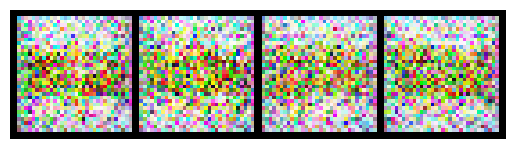

Epoch 2/150: 100%|██████████| 35/35 [00:02<00:00, 16.37it/s]


Epoch 2: D_loss=-35.502 | G_loss=-157.528


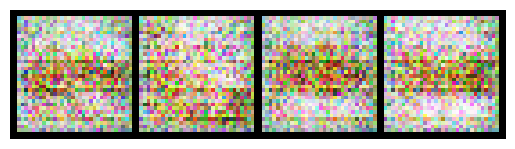

Epoch 3/150: 100%|██████████| 35/35 [00:01<00:00, 26.46it/s]

Epoch 3: D_loss=-49.240 | G_loss=-181.813


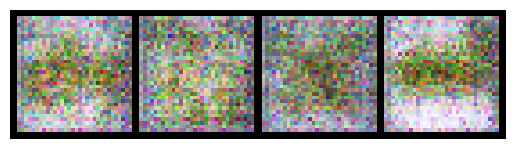

Epoch 4/150: 100%|██████████| 35/35 [00:01<00:00, 25.69it/s]

Epoch 4: D_loss=-50.821 | G_loss=-167.914


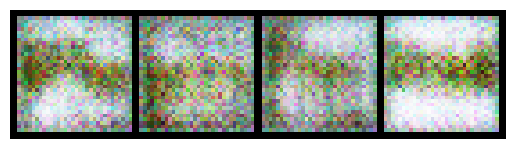

Epoch 5/150: 100%|██████████| 35/35 [00:01<00:00, 26.45it/s]


Epoch 5: D_loss=-42.001 | G_loss=-170.257


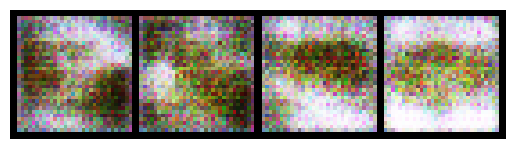

Epoch 6/150: 100%|██████████| 35/35 [00:01<00:00, 26.69it/s]


Epoch 6: D_loss=-44.939 | G_loss=-185.393


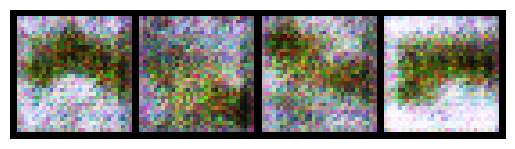

Epoch 7/150: 100%|██████████| 35/35 [00:01<00:00, 25.91it/s]

Epoch 7: D_loss=-46.650 | G_loss=-191.056


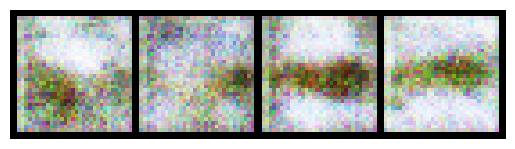

Epoch 8/150: 100%|██████████| 35/35 [00:01<00:00, 26.16it/s]


Epoch 8: D_loss=-47.545 | G_loss=-180.770


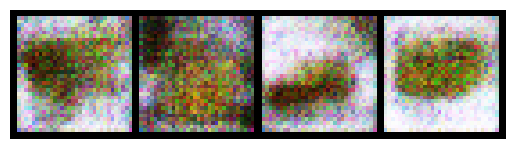

Epoch 9/150: 100%|██████████| 35/35 [00:01<00:00, 26.07it/s]


Epoch 9: D_loss=-43.603 | G_loss=-186.352


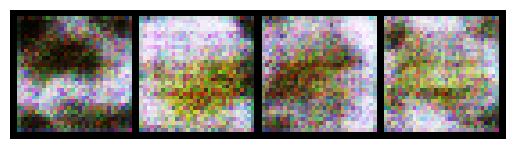

Epoch 10/150: 100%|██████████| 35/35 [00:02<00:00, 16.14it/s]

Epoch 10: D_loss=-35.972 | G_loss=-217.821


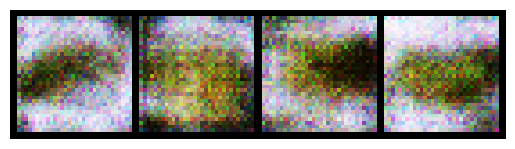

Epoch 11/150: 100%|██████████| 35/35 [00:01<00:00, 21.71it/s]


Epoch 11: D_loss=-39.833 | G_loss=-233.675


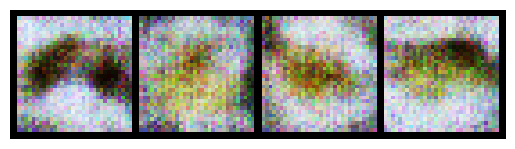

Epoch 12/150: 100%|██████████| 35/35 [00:01<00:00, 25.92it/s]

Epoch 12: D_loss=-38.043 | G_loss=-225.235


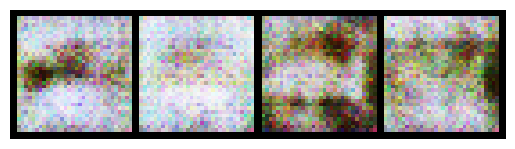

Epoch 13/150: 100%|██████████| 35/35 [00:01<00:00, 25.99it/s]

Epoch 13: D_loss=-46.853 | G_loss=-225.071


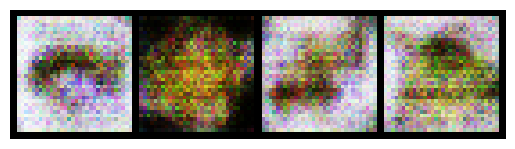

Epoch 14/150: 100%|██████████| 35/35 [00:01<00:00, 26.20it/s]

Epoch 14: D_loss=-48.106 | G_loss=-234.274


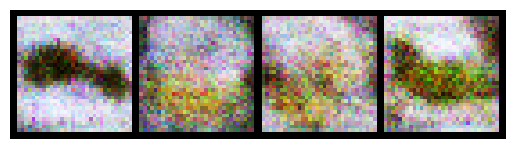

Epoch 15/150: 100%|██████████| 35/35 [00:01<00:00, 25.18it/s]

Epoch 15: D_loss=-50.492 | G_loss=-244.244


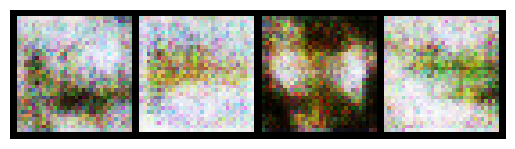

Epoch 16/150: 100%|██████████| 35/35 [00:01<00:00, 25.72it/s]

Epoch 16: D_loss=-56.381 | G_loss=-249.423


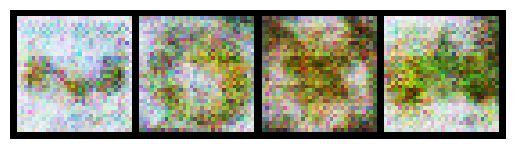

Epoch 17/150: 100%|██████████| 35/35 [00:01<00:00, 25.85it/s]


Epoch 17: D_loss=-62.801 | G_loss=-237.985


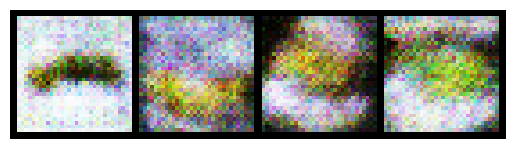

Epoch 18/150: 100%|██████████| 35/35 [00:02<00:00, 17.44it/s]


Epoch 18: D_loss=-63.691 | G_loss=-241.532


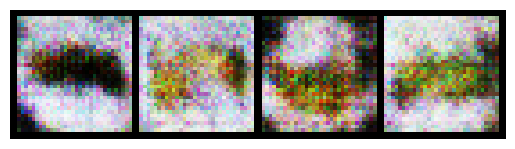

Epoch 19/150: 100%|██████████| 35/35 [00:01<00:00, 18.78it/s]


Epoch 19: D_loss=-63.019 | G_loss=-256.578


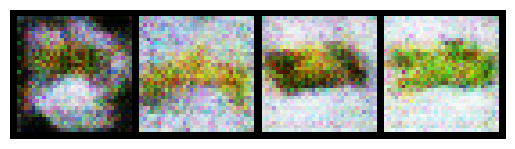

Epoch 20/150: 100%|██████████| 35/35 [00:01<00:00, 25.54it/s]

Epoch 20: D_loss=-63.957 | G_loss=-263.457


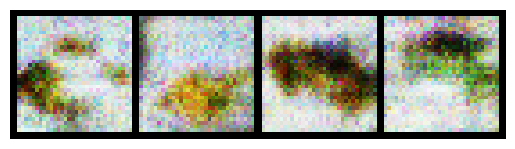

Epoch 21/150: 100%|██████████| 35/35 [00:01<00:00, 25.86it/s]

Epoch 21: D_loss=-68.333 | G_loss=-276.896


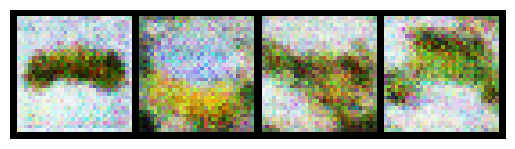

Epoch 22/150: 100%|██████████| 35/35 [00:01<00:00, 24.91it/s]

Epoch 22: D_loss=-69.966 | G_loss=-261.295


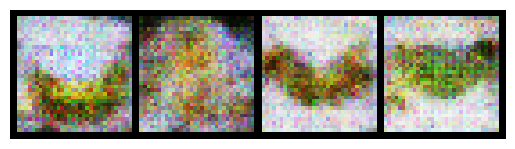

Epoch 23/150: 100%|██████████| 35/35 [00:01<00:00, 25.32it/s]

Epoch 23: D_loss=-65.428 | G_loss=-277.655


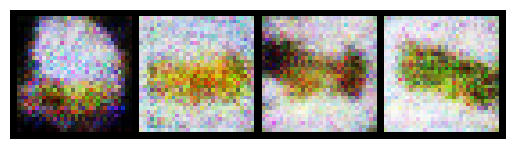

Epoch 24/150: 100%|██████████| 35/35 [00:01<00:00, 25.27it/s]

Epoch 24: D_loss=-67.419 | G_loss=-286.391


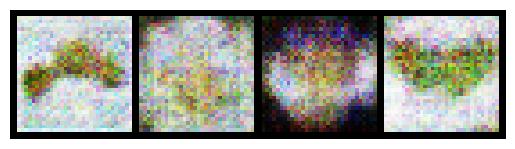

Epoch 25/150: 100%|██████████| 35/35 [00:01<00:00, 24.40it/s]

Epoch 25: D_loss=-69.548 | G_loss=-278.228


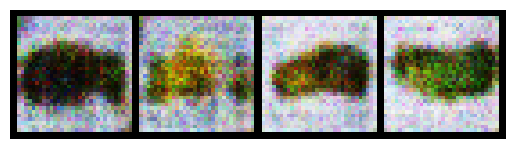

Epoch 26/150: 100%|██████████| 35/35 [00:01<00:00, 20.50it/s]

Epoch 26: D_loss=-71.892 | G_loss=-275.233


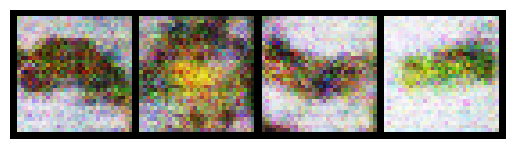

Epoch 27/150: 100%|██████████| 35/35 [00:02<00:00, 15.65it/s]


Epoch 27: D_loss=-72.460 | G_loss=-288.971


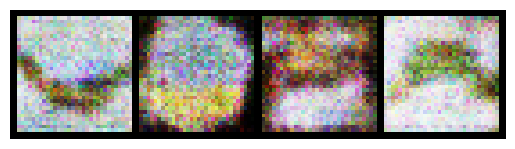

Epoch 28/150: 100%|██████████| 35/35 [00:01<00:00, 25.05it/s]

Epoch 28: D_loss=-72.831 | G_loss=-285.960


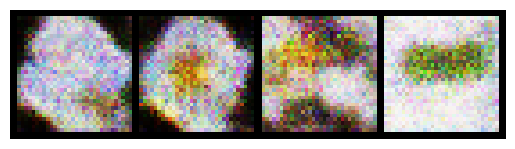

Epoch 29/150: 100%|██████████| 35/35 [00:01<00:00, 25.15it/s]


Epoch 29: D_loss=-70.018 | G_loss=-284.785


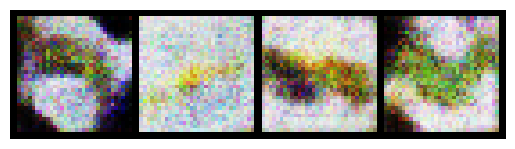

Epoch 30/150: 100%|██████████| 35/35 [00:01<00:00, 24.50it/s]

Epoch 30: D_loss=-75.673 | G_loss=-280.255


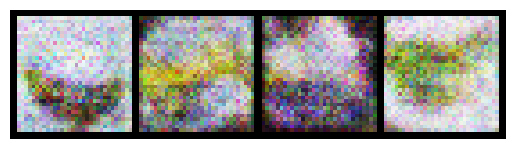

Epoch 31/150: 100%|██████████| 35/35 [00:01<00:00, 24.91it/s]

Epoch 31: D_loss=-80.742 | G_loss=-284.832


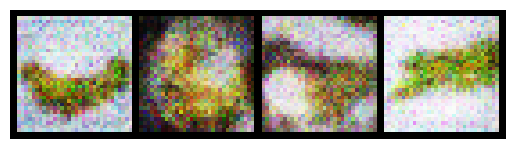

Epoch 32/150: 100%|██████████| 35/35 [00:01<00:00, 24.69it/s]

Epoch 32: D_loss=-82.766 | G_loss=-286.230


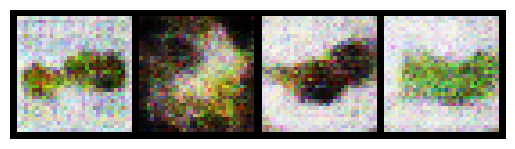

Epoch 33/150: 100%|██████████| 35/35 [00:01<00:00, 24.72it/s]

Epoch 33: D_loss=-81.511 | G_loss=-289.908


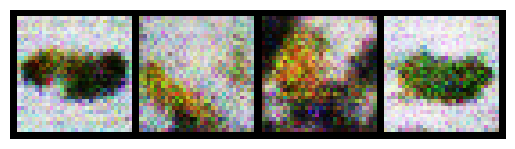

Epoch 34/150: 100%|██████████| 35/35 [00:01<00:00, 21.94it/s]

Epoch 34: D_loss=-88.746 | G_loss=-305.241


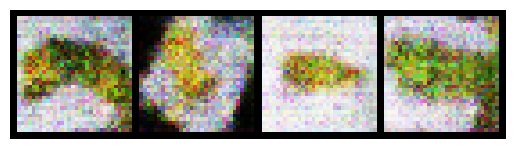

Epoch 35/150: 100%|██████████| 35/35 [00:02<00:00, 15.07it/s]

Epoch 35: D_loss=-85.083 | G_loss=-309.250


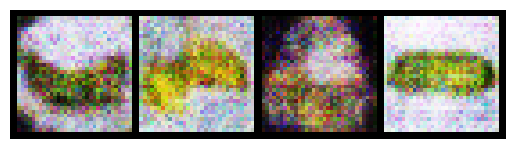

Epoch 36/150: 100%|██████████| 35/35 [00:01<00:00, 23.00it/s]

Epoch 36: D_loss=-89.849 | G_loss=-310.893


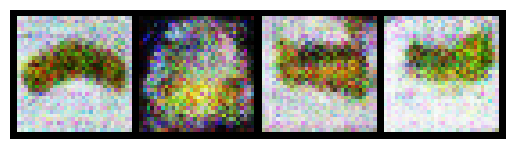

Epoch 37/150: 100%|██████████| 35/35 [00:01<00:00, 24.59it/s]

Epoch 37: D_loss=-90.027 | G_loss=-313.517


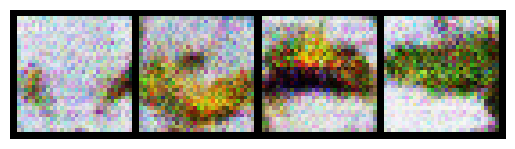

Epoch 38/150: 100%|██████████| 35/35 [00:01<00:00, 24.73it/s]

Epoch 38: D_loss=-89.914 | G_loss=-319.813


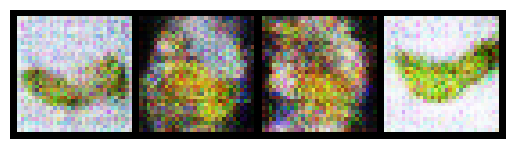

Epoch 39/150: 100%|██████████| 35/35 [00:01<00:00, 24.18it/s]

Epoch 39: D_loss=-92.960 | G_loss=-314.491


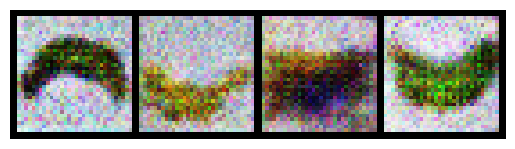

Epoch 40/150: 100%|██████████| 35/35 [00:01<00:00, 23.58it/s]

Epoch 40: D_loss=-95.105 | G_loss=-315.894


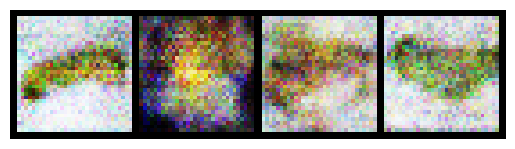

Epoch 41/150: 100%|██████████| 35/35 [00:01<00:00, 24.90it/s]

Epoch 41: D_loss=-96.041 | G_loss=-329.871


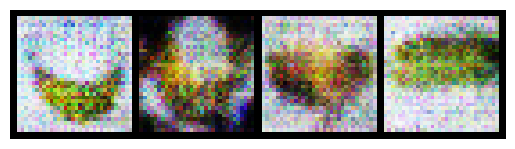

Epoch 42/150: 100%|██████████| 35/35 [00:01<00:00, 20.92it/s]


Epoch 42: D_loss=-101.846 | G_loss=-331.910


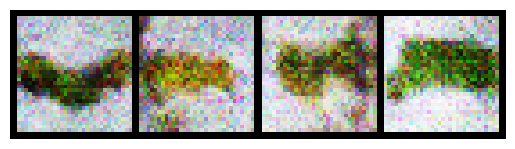

Epoch 43/150: 100%|██████████| 35/35 [00:02<00:00, 15.16it/s]


Epoch 43: D_loss=-100.001 | G_loss=-323.835


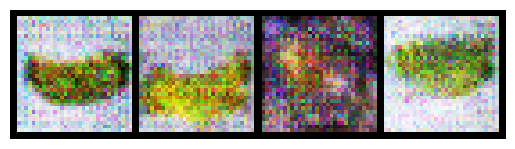

Epoch 44/150: 100%|██████████| 35/35 [00:01<00:00, 24.38it/s]

Epoch 44: D_loss=-98.270 | G_loss=-321.185


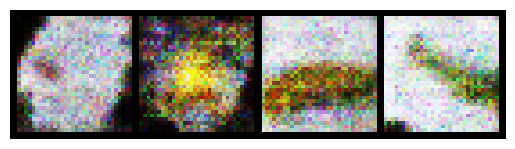

Epoch 45/150: 100%|██████████| 35/35 [00:01<00:00, 23.96it/s]

Epoch 45: D_loss=-102.469 | G_loss=-337.389


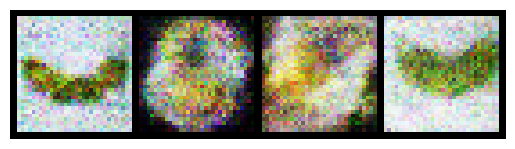

Epoch 46/150: 100%|██████████| 35/35 [00:01<00:00, 24.01it/s]


Epoch 46: D_loss=-112.016 | G_loss=-335.369


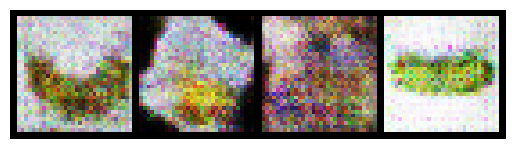

Epoch 47/150: 100%|██████████| 35/35 [00:01<00:00, 24.57it/s]

Epoch 47: D_loss=-105.231 | G_loss=-338.472


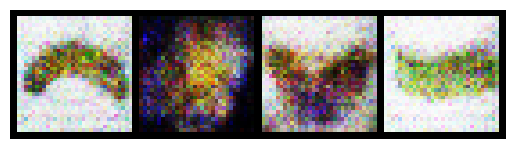

Epoch 48/150: 100%|██████████| 35/35 [00:01<00:00, 24.76it/s]


Epoch 48: D_loss=-108.618 | G_loss=-343.958


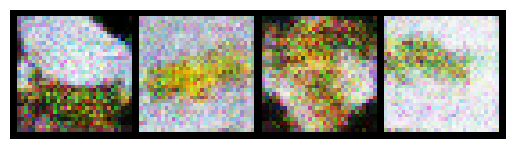

Epoch 49/150: 100%|██████████| 35/35 [00:01<00:00, 24.33it/s]

Epoch 49: D_loss=-103.116 | G_loss=-341.375


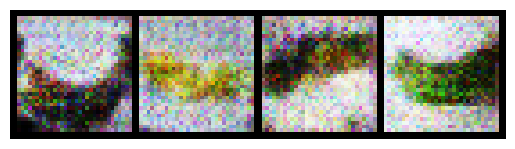

Epoch 50/150: 100%|██████████| 35/35 [00:01<00:00, 20.86it/s]


Epoch 50: D_loss=-110.092 | G_loss=-343.351


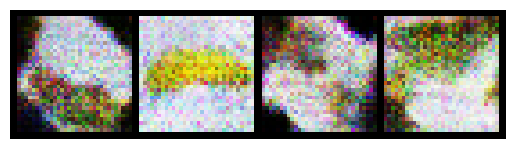

Epoch 51/150: 100%|██████████| 35/35 [00:02<00:00, 15.14it/s]


Epoch 51: D_loss=-110.460 | G_loss=-354.946


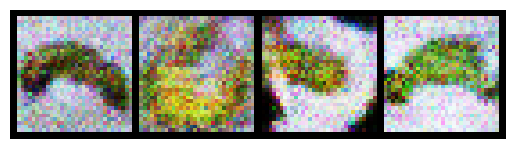

Epoch 52/150: 100%|██████████| 35/35 [00:01<00:00, 22.17it/s]

Epoch 52: D_loss=-112.748 | G_loss=-353.996


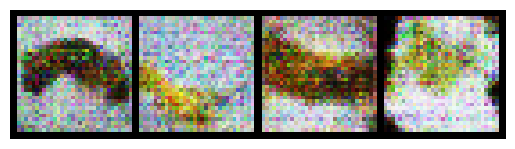

Epoch 53/150: 100%|██████████| 35/35 [00:01<00:00, 23.85it/s]


Epoch 53: D_loss=-116.276 | G_loss=-358.496


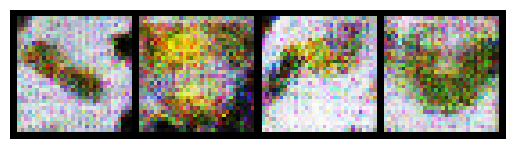

Epoch 54/150: 100%|██████████| 35/35 [00:01<00:00, 24.26it/s]

Epoch 54: D_loss=-118.063 | G_loss=-375.635


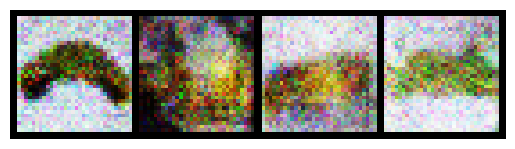

Epoch 55/150: 100%|██████████| 35/35 [00:01<00:00, 22.84it/s]

Epoch 55: D_loss=-115.466 | G_loss=-368.345


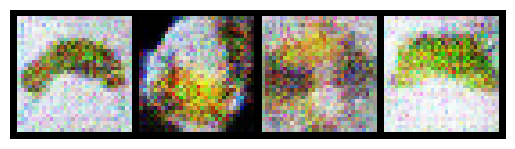

Epoch 56/150: 100%|██████████| 35/35 [00:01<00:00, 23.92it/s]

Epoch 56: D_loss=-117.480 | G_loss=-371.636


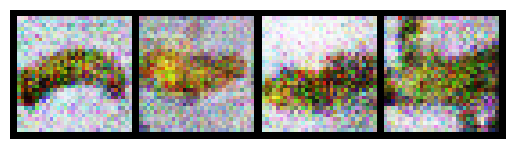

Epoch 57/150: 100%|██████████| 35/35 [00:01<00:00, 24.02it/s]

Epoch 57: D_loss=-114.135 | G_loss=-371.950


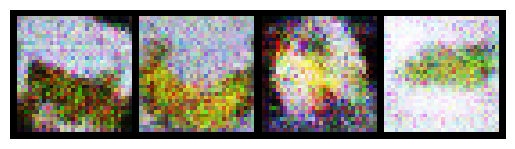

Epoch 58/150: 100%|██████████| 35/35 [00:01<00:00, 20.85it/s]


Epoch 58: D_loss=-118.935 | G_loss=-372.156


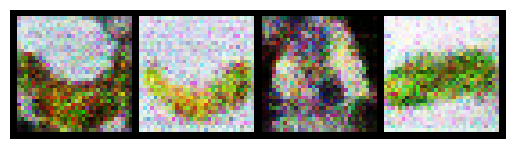

Epoch 59/150: 100%|██████████| 35/35 [00:02<00:00, 14.38it/s]


Epoch 59: D_loss=-116.809 | G_loss=-381.960


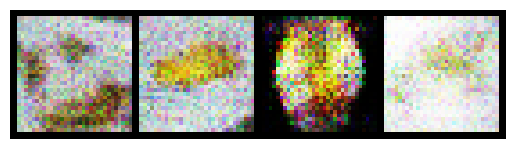

Epoch 60/150: 100%|██████████| 35/35 [00:01<00:00, 23.42it/s]


Epoch 60: D_loss=-123.226 | G_loss=-380.657


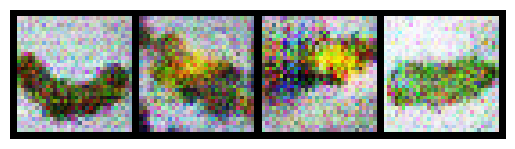

Epoch 61/150: 100%|██████████| 35/35 [00:01<00:00, 23.27it/s]

Epoch 61: D_loss=-123.132 | G_loss=-379.880


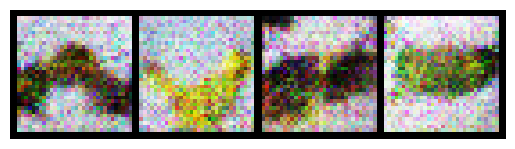

Epoch 62/150: 100%|██████████| 35/35 [00:01<00:00, 23.35it/s]

Epoch 62: D_loss=-123.342 | G_loss=-373.253


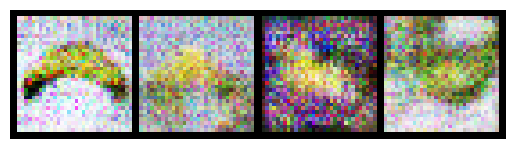

Epoch 63/150: 100%|██████████| 35/35 [00:01<00:00, 23.26it/s]


Epoch 63: D_loss=-126.813 | G_loss=-386.937


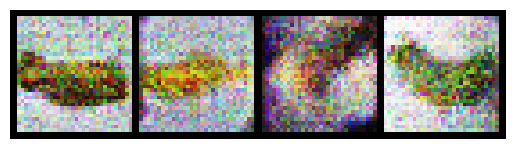

Epoch 64/150: 100%|██████████| 35/35 [00:01<00:00, 23.45it/s]


Epoch 64: D_loss=-126.146 | G_loss=-393.707


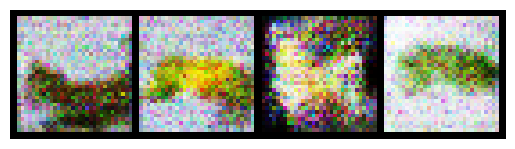

Epoch 65/150: 100%|██████████| 35/35 [00:01<00:00, 22.10it/s]

Epoch 65: D_loss=-124.707 | G_loss=-395.179


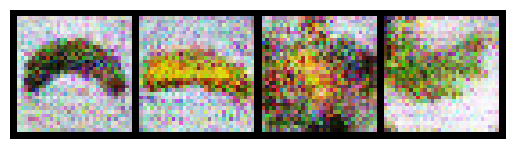

Epoch 66/150: 100%|██████████| 35/35 [00:02<00:00, 16.93it/s]

Epoch 66: D_loss=-128.278 | G_loss=-400.342


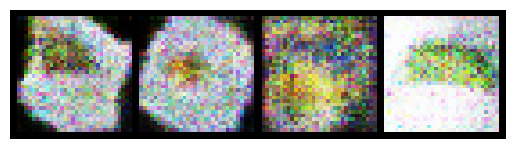

Epoch 67/150: 100%|██████████| 35/35 [00:02<00:00, 16.29it/s]

Epoch 67: D_loss=-124.789 | G_loss=-405.302


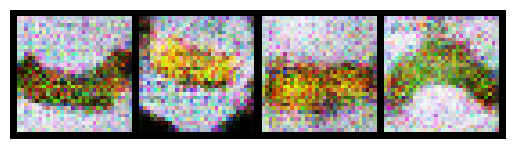

Epoch 68/150: 100%|██████████| 35/35 [00:01<00:00, 23.48it/s]

Epoch 68: D_loss=-133.498 | G_loss=-418.697


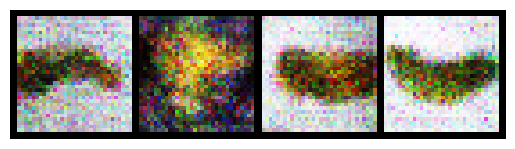

Epoch 69/150: 100%|██████████| 35/35 [00:01<00:00, 22.59it/s]

Epoch 69: D_loss=-129.221 | G_loss=-406.464


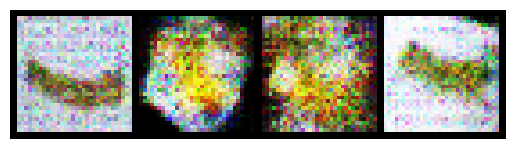

Epoch 70/150: 100%|██████████| 35/35 [00:01<00:00, 23.26it/s]

Epoch 70: D_loss=-134.559 | G_loss=-422.228


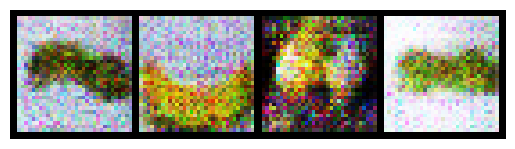

Epoch 71/150: 100%|██████████| 35/35 [00:01<00:00, 22.21it/s]


Epoch 71: D_loss=-128.671 | G_loss=-403.467


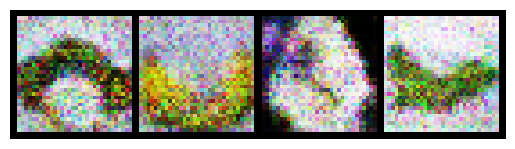

Epoch 72/150: 100%|██████████| 35/35 [00:01<00:00, 21.90it/s]


Epoch 72: D_loss=-132.815 | G_loss=-403.552


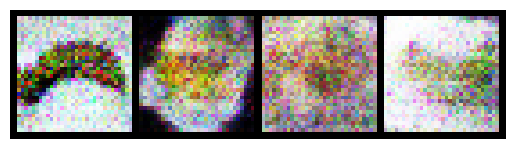

Epoch 73/150: 100%|██████████| 35/35 [00:01<00:00, 21.13it/s]

Epoch 73: D_loss=-132.871 | G_loss=-424.509


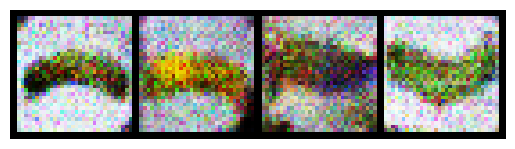

Epoch 74/150: 100%|██████████| 35/35 [00:02<00:00, 15.88it/s]

Epoch 74: D_loss=-135.535 | G_loss=-430.074


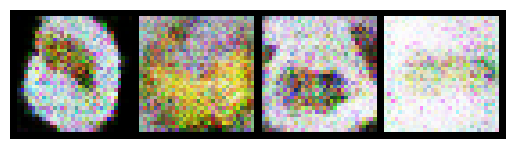

Epoch 75/150: 100%|██████████| 35/35 [00:02<00:00, 17.05it/s]

Epoch 75: D_loss=-142.328 | G_loss=-406.579


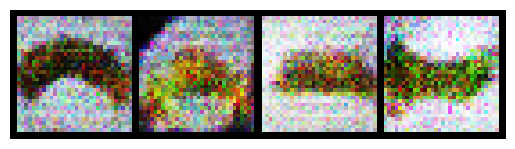

Epoch 76/150: 100%|██████████| 35/35 [00:01<00:00, 22.57it/s]

Epoch 76: D_loss=-138.052 | G_loss=-417.343


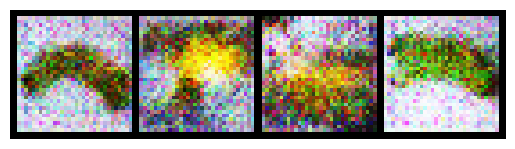

Epoch 77/150: 100%|██████████| 35/35 [00:01<00:00, 22.58it/s]

Epoch 77: D_loss=-134.113 | G_loss=-415.359


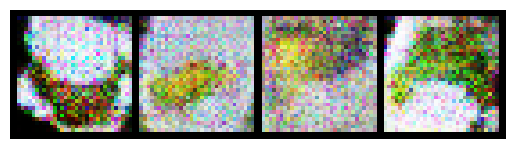

Epoch 78/150: 100%|██████████| 35/35 [00:01<00:00, 22.21it/s]

Epoch 78: D_loss=-140.898 | G_loss=-428.994


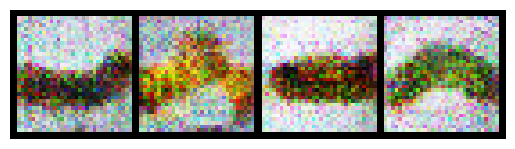

Epoch 79/150: 100%|██████████| 35/35 [00:01<00:00, 22.23it/s]

Epoch 79: D_loss=-140.018 | G_loss=-435.330


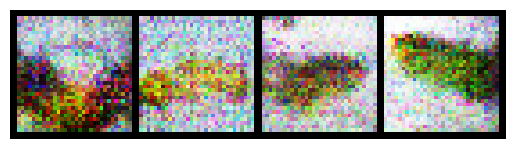

Epoch 80/150: 100%|██████████| 35/35 [00:01<00:00, 23.28it/s]

Epoch 80: D_loss=-142.862 | G_loss=-439.464


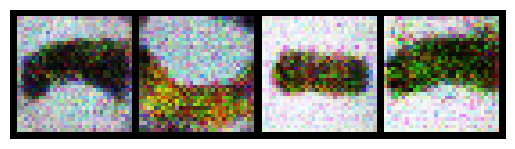

Epoch 81/150: 100%|██████████| 35/35 [00:01<00:00, 22.42it/s]

Epoch 81: D_loss=-146.641 | G_loss=-439.130


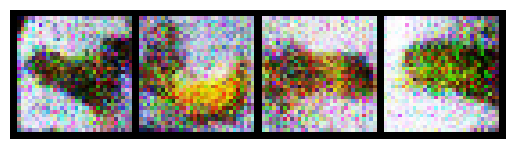

Epoch 82/150: 100%|██████████| 35/35 [00:02<00:00, 14.72it/s]

Epoch 82: D_loss=-145.858 | G_loss=-450.581


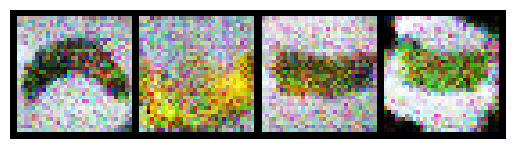

Epoch 83/150: 100%|██████████| 35/35 [00:01<00:00, 18.74it/s]

Epoch 83: D_loss=-140.297 | G_loss=-453.921


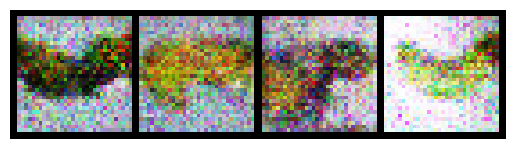

Epoch 84/150: 100%|██████████| 35/35 [00:01<00:00, 22.58it/s]

Epoch 84: D_loss=-143.742 | G_loss=-445.909


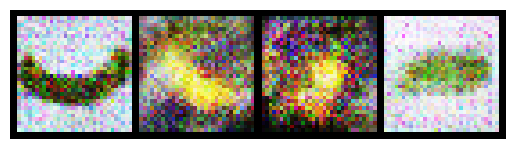

Epoch 85/150: 100%|██████████| 35/35 [00:01<00:00, 21.52it/s]

Epoch 85: D_loss=-145.069 | G_loss=-456.434


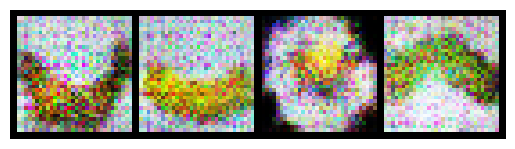

Epoch 86/150: 100%|██████████| 35/35 [00:01<00:00, 21.82it/s]

Epoch 86: D_loss=-153.682 | G_loss=-453.175


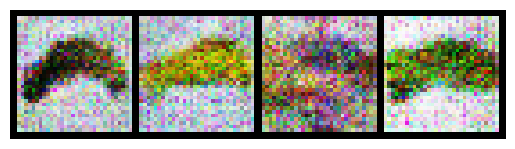

Epoch 87/150: 100%|██████████| 35/35 [00:01<00:00, 22.06it/s]


Epoch 87: D_loss=-147.734 | G_loss=-458.653


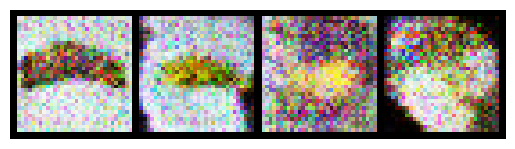

Epoch 88/150: 100%|██████████| 35/35 [00:01<00:00, 22.01it/s]

Epoch 88: D_loss=-144.131 | G_loss=-466.275


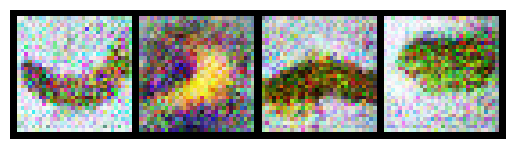

Epoch 89/150: 100%|██████████| 35/35 [00:01<00:00, 18.01it/s]

Epoch 89: D_loss=-153.586 | G_loss=-477.918


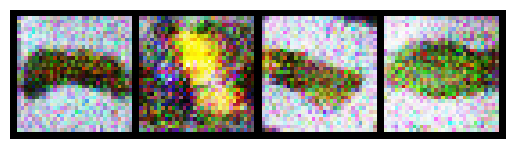

Epoch 90/150: 100%|██████████| 35/35 [00:02<00:00, 13.86it/s]


Epoch 90: D_loss=-150.044 | G_loss=-464.475


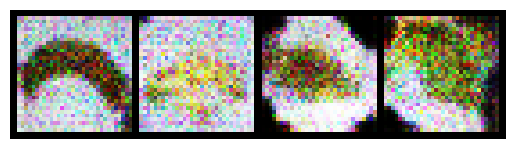

Epoch 91/150: 100%|██████████| 35/35 [00:01<00:00, 21.63it/s]

Epoch 91: D_loss=-147.737 | G_loss=-469.889


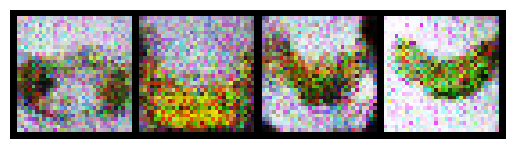

Epoch 92/150: 100%|██████████| 35/35 [00:01<00:00, 21.89it/s]

Epoch 92: D_loss=-156.150 | G_loss=-448.145


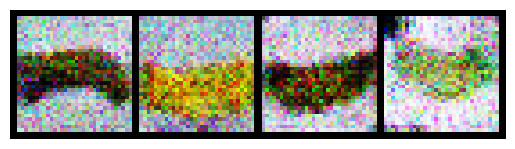

Epoch 93/150: 100%|██████████| 35/35 [00:01<00:00, 22.07it/s]

Epoch 93: D_loss=-156.586 | G_loss=-442.004


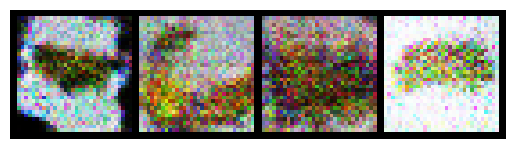

Epoch 94/150: 100%|██████████| 35/35 [00:01<00:00, 21.84it/s]

Epoch 94: D_loss=-151.486 | G_loss=-471.251


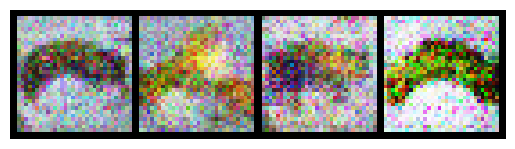

Epoch 95/150: 100%|██████████| 35/35 [00:01<00:00, 22.48it/s]


Epoch 95: D_loss=-156.600 | G_loss=-468.632


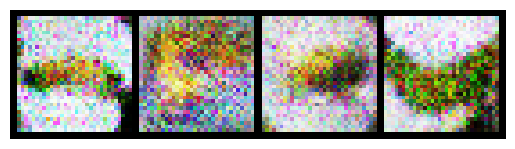

Epoch 96/150: 100%|██████████| 35/35 [00:01<00:00, 21.67it/s]

Epoch 96: D_loss=-160.571 | G_loss=-471.398


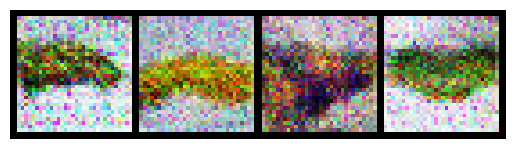

Epoch 97/150: 100%|██████████| 35/35 [00:02<00:00, 13.20it/s]

Epoch 97: D_loss=-153.382 | G_loss=-469.858


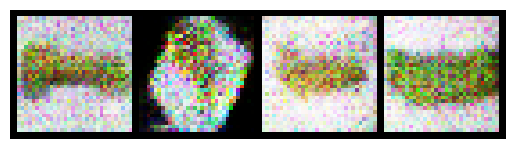

Epoch 98/150: 100%|██████████| 35/35 [00:01<00:00, 18.30it/s]


Epoch 98: D_loss=-162.976 | G_loss=-461.786


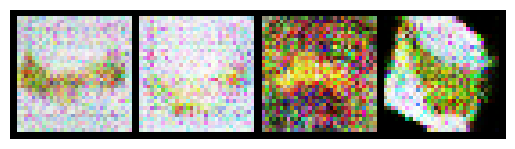

Epoch 99/150: 100%|██████████| 35/35 [00:01<00:00, 21.55it/s]

Epoch 99: D_loss=-155.241 | G_loss=-484.080


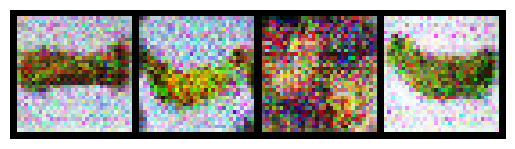

Epoch 100/150: 100%|██████████| 35/35 [00:01<00:00, 21.31it/s]


Epoch 100: D_loss=-158.070 | G_loss=-483.127


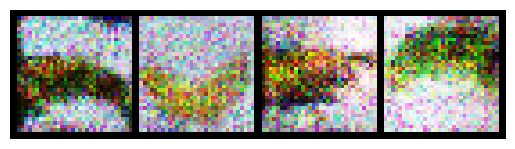

Epoch 101/150: 100%|██████████| 35/35 [00:01<00:00, 21.27it/s]

Epoch 101: D_loss=-158.140 | G_loss=-494.570


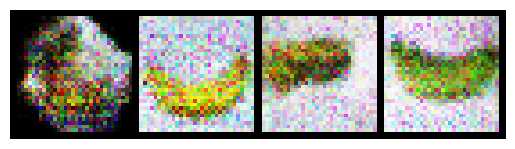

Epoch 102/150: 100%|██████████| 35/35 [00:01<00:00, 20.88it/s]


Epoch 102: D_loss=-158.078 | G_loss=-474.577


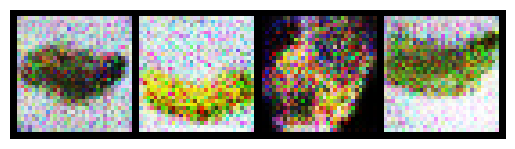

Epoch 103/150: 100%|██████████| 35/35 [00:01<00:00, 20.75it/s]


Epoch 103: D_loss=-159.556 | G_loss=-492.572


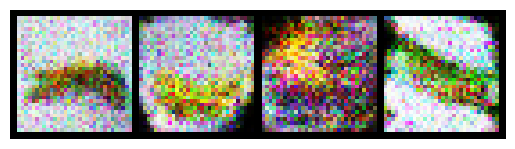

Epoch 104/150: 100%|██████████| 35/35 [00:02<00:00, 15.13it/s]


Epoch 104: D_loss=-159.269 | G_loss=-495.384


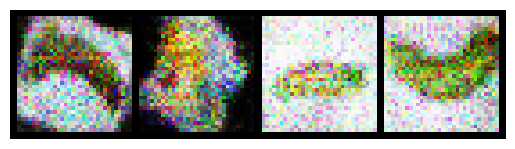

Epoch 105/150: 100%|██████████| 35/35 [00:02<00:00, 14.88it/s]

Epoch 105: D_loss=-160.706 | G_loss=-508.737


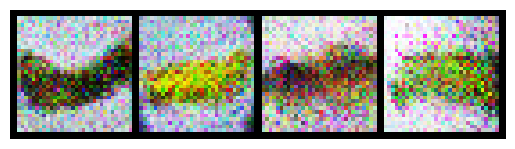

Epoch 106/150: 100%|██████████| 35/35 [00:01<00:00, 20.70it/s]


Epoch 106: D_loss=-161.221 | G_loss=-479.616


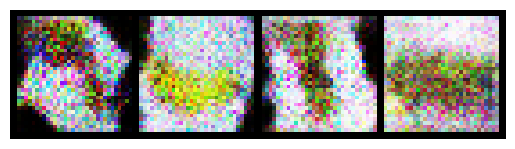

Epoch 107/150: 100%|██████████| 35/35 [00:01<00:00, 18.79it/s]

Epoch 107: D_loss=-165.861 | G_loss=-511.987


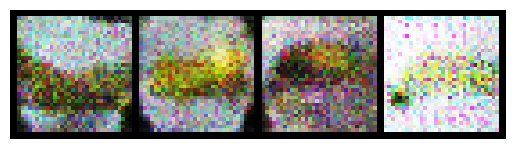

Epoch 108/150: 100%|██████████| 35/35 [00:02<00:00, 16.05it/s]

Epoch 108: D_loss=-167.194 | G_loss=-500.939


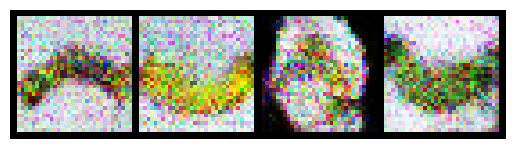

Epoch 109/150: 100%|██████████| 35/35 [00:01<00:00, 20.91it/s]

Epoch 109: D_loss=-167.984 | G_loss=-490.281


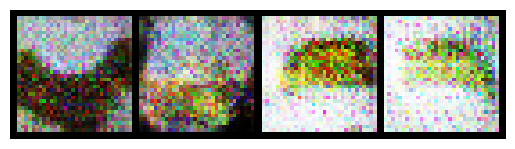

Epoch 110/150: 100%|██████████| 35/35 [00:01<00:00, 20.77it/s]

Epoch 110: D_loss=-170.428 | G_loss=-495.718


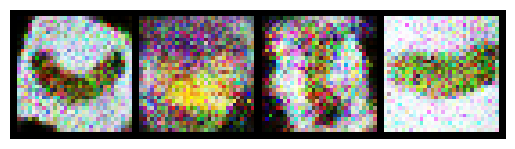

Epoch 111/150: 100%|██████████| 35/35 [00:02<00:00, 14.74it/s]

Epoch 111: D_loss=-166.172 | G_loss=-517.840


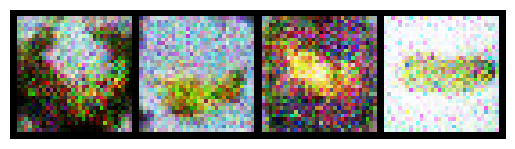

Epoch 112/150: 100%|██████████| 35/35 [00:02<00:00, 15.12it/s]

Epoch 112: D_loss=-174.610 | G_loss=-500.862


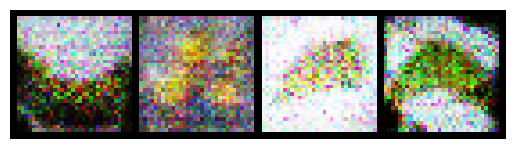

Epoch 113/150: 100%|██████████| 35/35 [00:01<00:00, 21.21it/s]

Epoch 113: D_loss=-166.355 | G_loss=-496.877


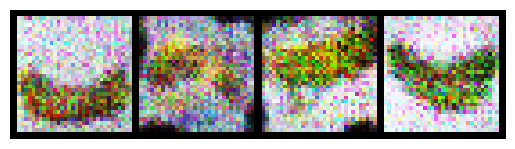

Epoch 114/150: 100%|██████████| 35/35 [00:01<00:00, 20.97it/s]


Epoch 114: D_loss=-166.973 | G_loss=-501.793


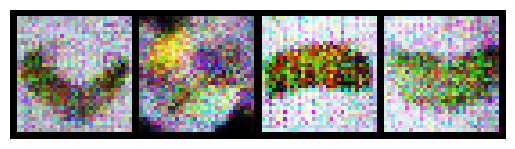

Epoch 115/150: 100%|██████████| 35/35 [00:01<00:00, 20.19it/s]

Epoch 115: D_loss=-167.137 | G_loss=-515.171


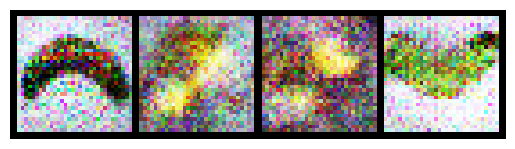

Epoch 116/150: 100%|██████████| 35/35 [00:01<00:00, 20.08it/s]

Epoch 116: D_loss=-167.663 | G_loss=-514.595


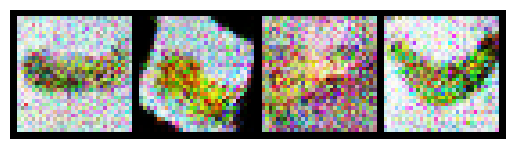

Epoch 117/150: 100%|██████████| 35/35 [00:01<00:00, 18.96it/s]

Epoch 117: D_loss=-175.742 | G_loss=-534.658


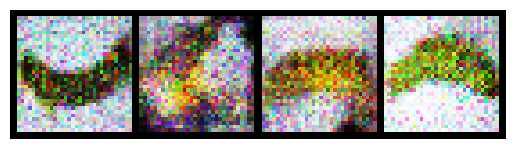

Epoch 118/150: 100%|██████████| 35/35 [00:02<00:00, 14.91it/s]


Epoch 118: D_loss=-171.929 | G_loss=-512.668


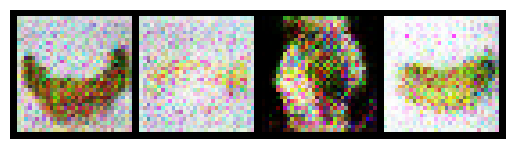

Epoch 119/150: 100%|██████████| 35/35 [00:02<00:00, 13.92it/s]

Epoch 119: D_loss=-164.251 | G_loss=-533.896


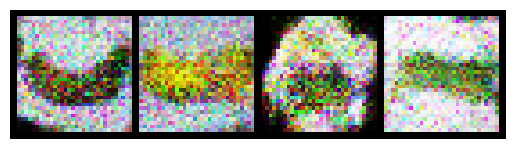

Epoch 120/150: 100%|██████████| 35/35 [00:01<00:00, 19.67it/s]

Epoch 120: D_loss=-167.863 | G_loss=-525.555


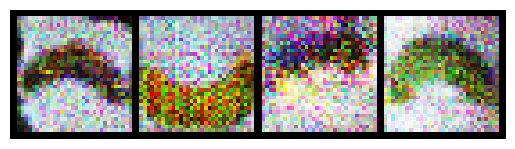

Epoch 121/150: 100%|██████████| 35/35 [00:01<00:00, 19.52it/s]

Epoch 121: D_loss=-176.977 | G_loss=-527.409


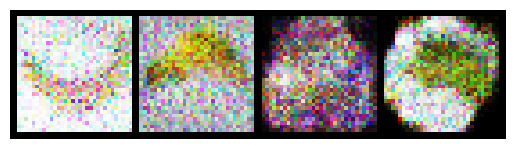

Epoch 122/150: 100%|██████████| 35/35 [00:01<00:00, 18.60it/s]

Epoch 122: D_loss=-182.883 | G_loss=-537.497


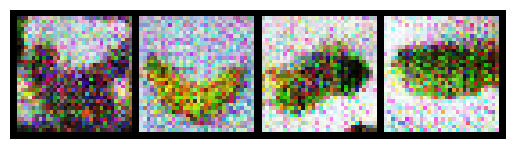

Epoch 123/150: 100%|██████████| 35/35 [00:01<00:00, 18.98it/s]

Epoch 123: D_loss=-170.646 | G_loss=-531.182


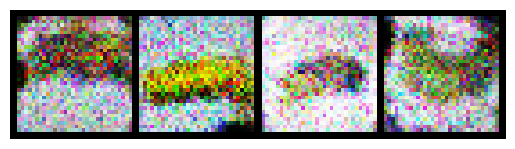

Epoch 124/150: 100%|██████████| 35/35 [00:01<00:00, 18.71it/s]

Epoch 124: D_loss=-171.047 | G_loss=-527.271


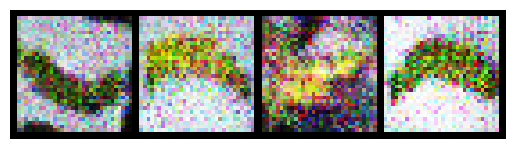

Epoch 125/150: 100%|██████████| 35/35 [00:02<00:00, 14.03it/s]

Epoch 125: D_loss=-178.369 | G_loss=-511.552


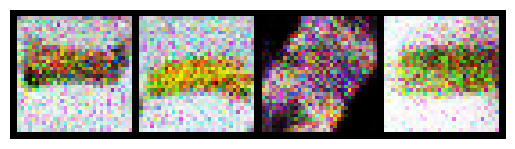

Epoch 126/150: 100%|██████████| 35/35 [00:02<00:00, 14.70it/s]

Epoch 126: D_loss=-174.391 | G_loss=-531.154


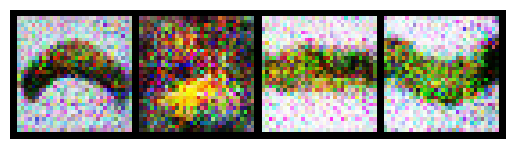

Epoch 127/150: 100%|██████████| 35/35 [00:01<00:00, 19.49it/s]

Epoch 127: D_loss=-177.078 | G_loss=-528.529


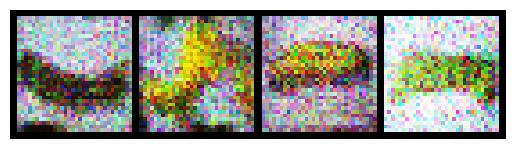

Epoch 128/150: 100%|██████████| 35/35 [00:01<00:00, 20.26it/s]

Epoch 128: D_loss=-177.766 | G_loss=-524.561


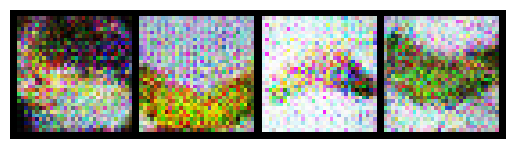

Epoch 129/150: 100%|██████████| 35/35 [00:01<00:00, 19.58it/s]

Epoch 129: D_loss=-175.744 | G_loss=-540.151


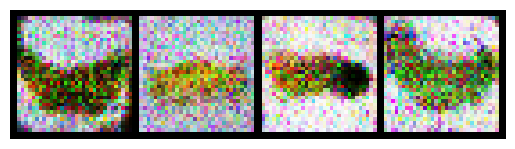

Epoch 130/150: 100%|██████████| 35/35 [00:01<00:00, 19.66it/s]


Epoch 130: D_loss=-175.330 | G_loss=-534.785


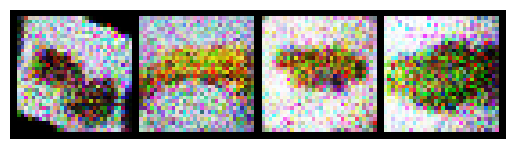

Epoch 131/150: 100%|██████████| 35/35 [00:01<00:00, 19.16it/s]


Epoch 131: D_loss=-177.653 | G_loss=-537.463


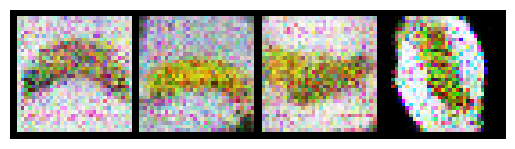

Epoch 132/150: 100%|██████████| 35/35 [00:02<00:00, 14.17it/s]


Epoch 132: D_loss=-183.844 | G_loss=-538.390


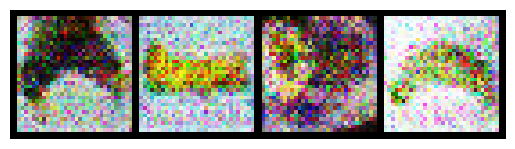

Epoch 133/150: 100%|██████████| 35/35 [00:02<00:00, 14.51it/s]


Epoch 133: D_loss=-183.966 | G_loss=-539.812


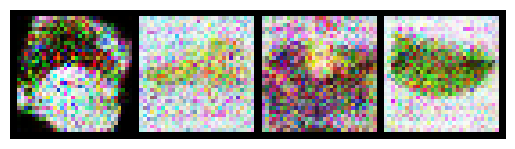

Epoch 134/150: 100%|██████████| 35/35 [00:01<00:00, 19.56it/s]


Epoch 134: D_loss=-175.850 | G_loss=-546.898


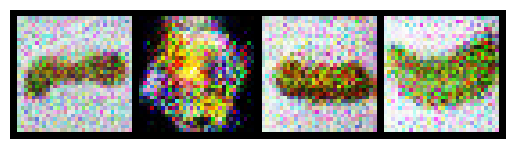

Epoch 135/150: 100%|██████████| 35/35 [00:01<00:00, 19.37it/s]

Epoch 135: D_loss=-180.331 | G_loss=-552.914


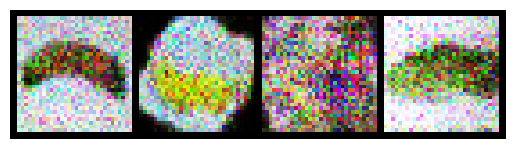

Epoch 136/150: 100%|██████████| 35/35 [00:01<00:00, 19.27it/s]

Epoch 136: D_loss=-177.986 | G_loss=-543.977


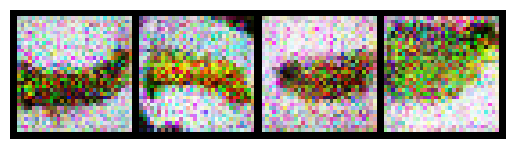

Epoch 137/150: 100%|██████████| 35/35 [00:01<00:00, 18.44it/s]

Epoch 137: D_loss=-179.479 | G_loss=-546.531


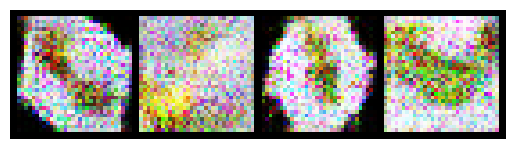

Epoch 138/150: 100%|██████████| 35/35 [00:01<00:00, 18.66it/s]


Epoch 138: D_loss=-179.731 | G_loss=-542.371


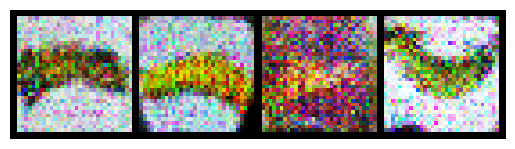

Epoch 139/150: 100%|██████████| 35/35 [00:02<00:00, 13.49it/s]


Epoch 139: D_loss=-183.269 | G_loss=-549.124


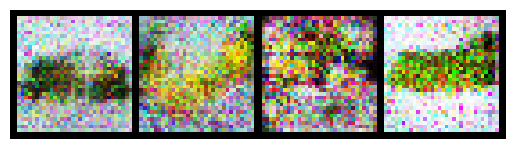

Epoch 140/150: 100%|██████████| 35/35 [00:02<00:00, 14.69it/s]

Epoch 140: D_loss=-185.109 | G_loss=-551.544


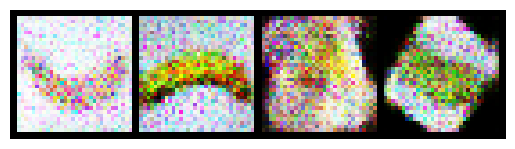

Epoch 141/150: 100%|██████████| 35/35 [00:01<00:00, 19.72it/s]

Epoch 141: D_loss=-175.089 | G_loss=-549.473


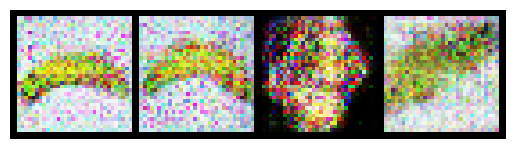

Epoch 142/150: 100%|██████████| 35/35 [00:01<00:00, 18.83it/s]

Epoch 142: D_loss=-187.167 | G_loss=-535.916


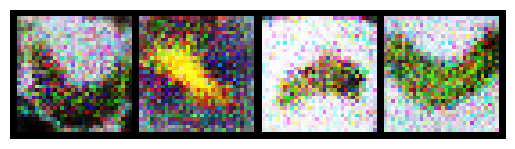

Epoch 143/150: 100%|██████████| 35/35 [00:01<00:00, 18.66it/s]

Epoch 143: D_loss=-189.320 | G_loss=-560.409


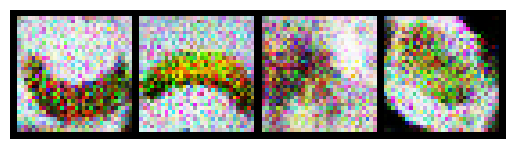

Epoch 144/150: 100%|██████████| 35/35 [00:01<00:00, 18.84it/s]

Epoch 144: D_loss=-183.928 | G_loss=-561.383


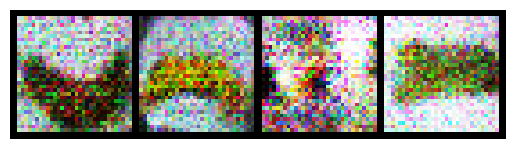

Epoch 145/150: 100%|██████████| 35/35 [00:01<00:00, 19.06it/s]

Epoch 145: D_loss=-181.429 | G_loss=-573.302


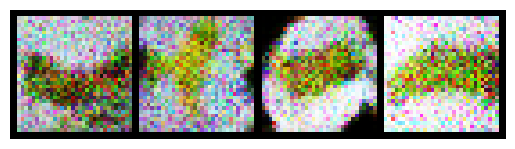

Epoch 146/150: 100%|██████████| 35/35 [00:02<00:00, 12.70it/s]

Epoch 146: D_loss=-189.613 | G_loss=-542.636


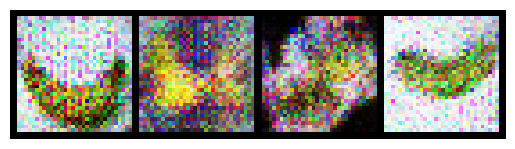

Epoch 147/150: 100%|██████████| 35/35 [00:02<00:00, 14.99it/s]


Epoch 147: D_loss=-196.100 | G_loss=-557.448


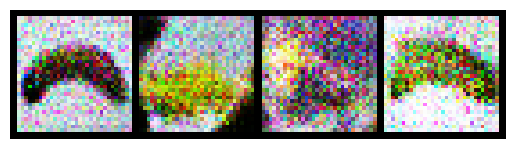

Epoch 148/150: 100%|██████████| 35/35 [00:01<00:00, 19.09it/s]

Epoch 148: D_loss=-186.362 | G_loss=-555.912


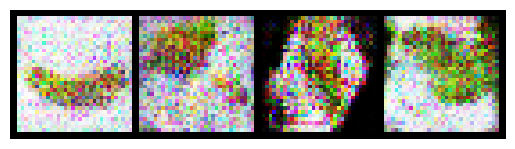

Epoch 149/150: 100%|██████████| 35/35 [00:01<00:00, 18.06it/s]


Epoch 149: D_loss=-180.828 | G_loss=-559.932


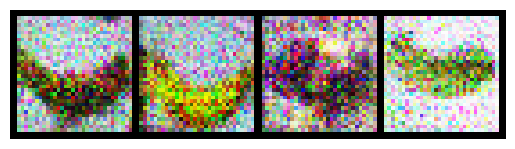

Epoch 150/150: 100%|██████████| 35/35 [00:01<00:00, 19.13it/s]

Epoch 150: D_loss=-183.314 | G_loss=-586.014


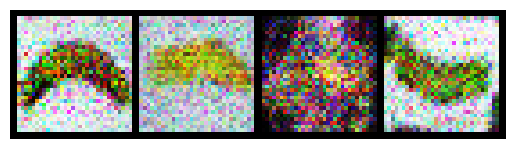

Done generating synthetic images!


In [ ]:

#GAN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import os, shutil
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


ROOT = Path("/content/banana")
IMG_DIR = ROOT / "clean_dataset"
SYN_DIR = ROOT / "synthetic"
if SYN_DIR.exists():
    shutil.rmtree(SYN_DIR)
SYN_DIR.mkdir(parents=True, exist_ok=True)


IMG_SIZE = 32
BATCH = 16
nz = 64
num_classes = 4            # overripe, ripe, rotten, unripe
embedding_dim = 16
ngf = 32
ndf = 32
lambda_gp = 10
EPOCHS = 150



transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


dataset = datasets.ImageFolder(str(IMG_DIR), transform=transform)
loader = DataLoader(dataset, batch_size=BATCH, shuffle=True, drop_last=True, num_workers=2)

class_names = dataset.classes
print("Classes:", class_names)


#Conditional Generator

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)

        self.fc = nn.Sequential(
            nn.Linear(nz + embedding_dim, ngf * 8 * 4 * 4),
            nn.ReLU(True),
        )

        self.main = nn.Sequential(
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, 3, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_emb = self.label_emb(labels)
        x = torch.cat([noise, label_emb], dim=1)
        x = self.fc(x)
        x = x.view(-1, ngf*8, 4, 4)
        return self.main(x)


# Conditional Discriminator

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, IMG_SIZE * IMG_SIZE)

        self.main = nn.Sequential(
            nn.Conv2d(4, ndf, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1),
            nn.InstanceNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1),
            nn.InstanceNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, 1, 4, 1, 0)
        )

    def forward(self, img, labels):
        label_map = self.label_emb(labels)
        label_map = label_map.view(-1, 1, IMG_SIZE, IMG_SIZE)
        x = torch.cat([img, label_map], dim=1)
        return self.main(x).view(-1)


netG = Generator().to(DEVICE)
netD = Discriminator().to(DEVICE)

optG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.0, 0.9))
optD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.0, 0.9))

print("Models Ready")

#Penalty
def gradient_penalty(D, real, fake, labels):
    alpha = torch.rand(real.size(0), 1, 1, 1, device=DEVICE)
    interpolated = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    out = D(interpolated, labels)

    gradients = torch.autograd.grad(
        outputs=out, inputs=interpolated,
        grad_outputs=torch.ones_like(out),
        create_graph=True, retain_graph=True
    )[0]

    gradients = gradients.view(real.size(0), -1)
    return ((gradients.norm(2, dim=1) - 1)**2).mean()

def train():
    for epoch in range(EPOCHS):
        d_loss_epoch, g_loss_epoch = 0, 0

        for real_imgs, labels in tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            real_imgs, labels = real_imgs.to(DEVICE), labels.to(DEVICE)
            b = real_imgs.size(0)

            # Train D
            noise = torch.randn(b, nz, device=DEVICE)
            fake_imgs = netG(noise, labels).detach()

            real_score = netD(real_imgs, labels)
            fake_score = netD(fake_imgs, labels)
            gp = gradient_penalty(netD, real_imgs, fake_imgs, labels)

            d_loss = -(real_score.mean() - fake_score.mean()) + lambda_gp * gp

            optD.zero_grad()
            d_loss.backward()
            optD.step()

            # Train G
            noise = torch.randn(b, nz, device=DEVICE)
            fake_imgs = netG(noise, labels)

            g_loss = -netD(fake_imgs, labels).mean()

            optG.zero_grad()
            g_loss.backward()
            optG.step()

            d_loss_epoch += d_loss.item()
            g_loss_epoch += g_loss.item()

        print(f"Epoch {epoch+1}: D_loss={d_loss_epoch:.3f} | G_loss={g_loss_epoch:.3f}")


        with torch.no_grad():
            sample_labels = torch.tensor([0,1,2,3], device=DEVICE)
            noise = torch.randn(4, nz, device=DEVICE)
            samples = netG(noise, sample_labels).cpu()
            grid = utils.make_grid((samples+1)/2, nrow=4)
            plt.imshow(grid.permute(1,2,0))
            plt.axis("off")
            plt.show()

train()


def generate_images(n_per_class=100):
    netG.eval()
    for cls_idx, cls in enumerate(class_names):
        folder = SYN_DIR / cls
        folder.mkdir(exist_ok=True, parents=True)

        for i in range(n_per_class):
            noise = torch.randn(1, nz, device=DEVICE)
            label = torch.tensor([cls_idx], device=DEVICE)
            fake = netG(noise, label)[0].cpu()
            img = transforms.ToPILImage()( (fake+1)/2 )
            img.save(folder / f"{cls}_{i:04d}.png")

    print("Done generating synthetic images!")

generate_images(150)


In [ ]:
FINAL = ROOT / "final_dataset"
if FINAL.exists(): shutil.rmtree(FINAL)
shutil.copytree(str(AUG_DIR), str(FINAL))


for cls in class_names:
    dst = FINAL/cls
    for f in (SYN_DIR/cls).glob("*"):
        shutil.copy(str(f), str(dst))


In [ ]:
import os
from pathlib import Path

ROOT = Path("/content/banana")
FINAL_DIR = ROOT / "final_dataset"

# Remove any .ipynb_checkpoints
for r, d, f in os.walk(FINAL_DIR):
    if ".ipynb_checkpoints" in d:
        shutil.rmtree(os.path.join(r, ".ipynb_checkpoints"))

# Count images in each class folder
for cls in sorted([p.name for p in FINAL_DIR.iterdir() if p.is_dir()]):
    count = len(list((FINAL_DIR / cls).glob("*")))
    print(cls, "->", count)


overripe -> 1480
ripe -> 1890
rotten -> 2200
unripe -> 1450


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1/20] train_acc 0.5110 val_acc 0.7222 loss 1.1646
[2/20] train_acc 0.6987 val_acc 0.7991 loss 0.8788
[3/20] train_acc 0.7418 val_acc 0.8063 loss 0.7564
[4/20] train_acc 0.7655 val_acc 0.8191 loss 0.6835
[5/20] train_acc 0.7676 val_acc 0.8063 loss 0.6459
[6/20] train_acc 0.7824 val_acc 0.8048 loss 0.6091
[7/20] train_acc 0.7877 val_acc 0.8333 loss 0.5903
[8/20] train_acc 0.7942 val_acc 0.8177 loss 0.5685
[9/20] train_acc 0.7936 val_acc 0.8262 loss 0.5605
[10/20] train_acc 0.7938 val_acc 0.8348 loss 0.5564
[11/20] train_acc 0.8032 val_acc 0.8305 loss 0.5393
[12/20] train_acc 0.8016 val_acc 0.8319 loss 0.5351
[13/20] train_acc 0.8095 val_acc 0.8333 loss 0.5186
[14/20] train_acc 0.7972 val_acc 0.8276 loss 0.5204
[15/20] train_acc 0.8031 val_acc 0.8276 loss 0.5123
[16/20] train_acc 0.8134 val_acc 0.8262 loss 0.4955
[17/20] train_acc 0.8084 val_acc 0.8305 loss 0.4989
[18/20] train_acc 0.8093 val_acc 0.8333 loss 0.4996
[19/20] train_acc 0.8080 val_acc 0.8262 loss 0.5030
[20/20] train_acc 0.8

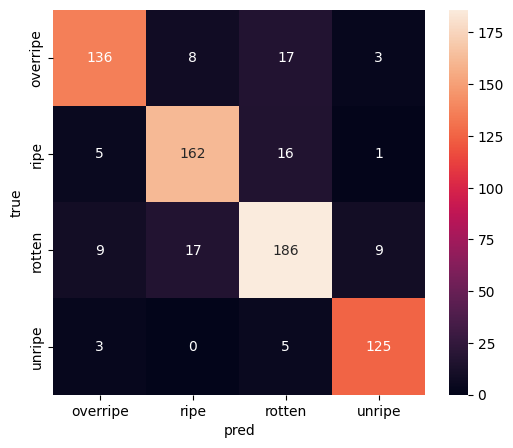

In [ ]:

import torch.nn as nn, torch.optim as optim
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# hyperparams
NUM_EPOCHS = 20
BATCH_CLS = 32
IMG_CLS = 224
LR = 1e-4


train_t = transforms.Compose([
    transforms.RandomResizedCrop(IMG_CLS),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_t = transforms.Compose([
    transforms.Resize((IMG_CLS,IMG_CLS)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

full = datasets.ImageFolder(str(FINAL), transform=train_t)
# split train/val/test 80/10/10
n = len(full)
n_train = int(0.8*n)
n_val = int(0.1*n)
n_test = n - n_train - n_val
train_ds, val_ds, test_ds = torch.utils.data.random_split(full, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42))

val_ds.dataset = datasets.ImageFolder(str(FINAL), transform=val_t)
test_ds.dataset = datasets.ImageFolder(str(FINAL), transform=val_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_CLS, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_CLS, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_CLS, shuffle=False, num_workers=2)

# model
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, len(class_names))
model = model.to(device)

#  (freeze backbone)
for p in model.features.parameters():
    p.requires_grad = False

criterion = nn.CrossEntropyLoss()
opt = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

best_val = 0.0
for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    running_loss = 0.0
    correct = total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        opt.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        opt.step()
        running_loss += loss.item()*imgs.size(0)
        preds = out.argmax(dim=1)
        correct += (preds==labels).sum().item()
        total += imgs.size(0)
    train_acc = correct/total
    # val
    model.eval()
    vcorrect = vtotal = 0
    vloss = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            loss = criterion(out, labels)
            vloss += loss.item()*imgs.size(0)
            preds = out.argmax(dim=1)
            vcorrect += (preds==labels).sum().item()
            vtotal += imgs.size(0)
    val_acc = vcorrect/vtotal
    print(f"[{epoch}/{NUM_EPOCHS}] train_acc {train_acc:.4f} val_acc {val_acc:.4f} loss {running_loss/total:.4f}")
    if val_acc > best_val:
        best_val = val_acc
        torch.save(model.state_dict(), MODEL_DIR / "mobilenet_final.pth")

# Evaluate on test set
model.load_state_dict(torch.load(MODEL_DIR/"mobilenet_final.pth"))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        out = model(imgs)
        preds = out.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(labels.numpy().tolist())

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=class_names))
# confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("pred"); plt.ylabel("true"); plt.show()
